## Подключение библиотек

In [1]:
import pandas as pd
import numpy as np

# визуализация
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# кластеризация и датасеты
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import datasets

# схожесть строк
from leven import levenshtein
from Bio.Seq import Seq
from Bio.pairwise2 import align, format_alignment
from Bio import Align

## Настройки и константы

In [2]:
COLORS_LIST = ['darkcyan', 'deeppink']
sns.set_palette(sns.color_palette(COLORS_LIST))

In [3]:
SEED = 42
RANGE = (-1, 1)
N_SAMPLES = 1500
FIGSIZE = (5, 5)
MULTIPLOT_FIGZSIZE = (FIGSIZE[0] * 3 + 2, FIGSIZE[1])

## Кластеризация

## Вспомогательные функции

Отрисовка оригинального датасета

In [4]:
def create_plot_for_original_data(some_noisy_df, to_make_hue_=False):
    _, ax = plt.subplots(figsize=FIGSIZE)
    if to_make_hue_:
        sns.scatterplot(data=some_noisy_df, x='x', y='y', hue='num')
    else:
        sns.scatterplot(data=some_noisy_df, x='x', y='y')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)

Получение меток для датасета разными алгоритмами кластеризации

In [5]:
def get_labels(noisy_df, n_clusters_=2):
    hierarchial_labels = AgglomerativeClustering(n_clusters=n_clusters_, linkage='average').fit_predict(noisy_df)
    kmeans_labels = KMeans(n_clusters=n_clusters_, random_state=SEED).fit_predict(noisy_df)
    dbscan_labels = DBSCAN(eps=0.2).fit_predict(noisy_df)

    noisy_df['hierarchial_labels'] = hierarchial_labels
    noisy_df['kmeans_labels'] = kmeans_labels
    noisy_df['dbscan_labels'] = dbscan_labels

Отрисовка датасета с раскраской

In [6]:
def create_plot_for_clusters(noisy_df_with_labels):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=MULTIPLOT_FIGZSIZE)

    sns.scatterplot(ax=ax1, data=noisy_df_with_labels, x='x', y='y', hue='hierarchial_labels') 
    ax1.grid(True)
    ax1.set_title("AgglomerativeClustering")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    sns.scatterplot(ax=ax2, data=noisy_df_with_labels, x='x', y='y', hue='kmeans_labels')   
    ax2.grid(True)
    ax2.set_title("KMeans")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")

    sns.scatterplot(ax=ax3, data=noisy_df_with_labels, x='x', y='y', hue='dbscan_labels')   
    ax3.grid(True)
    ax3.set_title("DBSCAN")
    ax3.set_xlabel("x")
    ax3.set_ylabel("y");

### Пример

Создание датасета - две зашумленных окружности разных диаметров с центром в одной точке

In [7]:
noisy_circles = datasets.make_circles(n_samples=N_SAMPLES, factor=0.5, noise=0.05, random_state=SEED)
noisy_circles_df = pd.DataFrame({'x': noisy_circles[0][:, 0], 'y': noisy_circles[0][:, 1], 'num': noisy_circles[1]})

display(noisy_circles_df)

,x,y,num
0,-0.490097,0.037513,1
1,0.219836,-0.399650,1
2,-0.854565,-0.349471,0
3,-0.956407,-0.256714,0
4,-0.878756,-0.630345,0
...,...,...,...
1495,-0.499526,-0.029710,1
1496,0.006396,-0.406022,1
1497,0.295080,0.380969,1
1498,0.395450,-0.168596,1


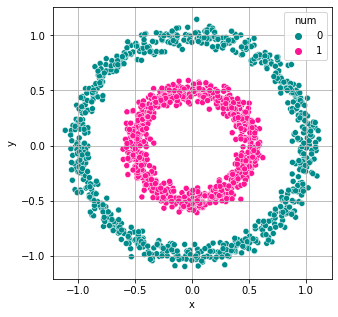

In [8]:
create_plot_for_original_data(noisy_circles_df, to_make_hue_=True)

Работа алгоритмов кластеризации на созданном датасете

In [9]:
get_labels(noisy_circles_df)

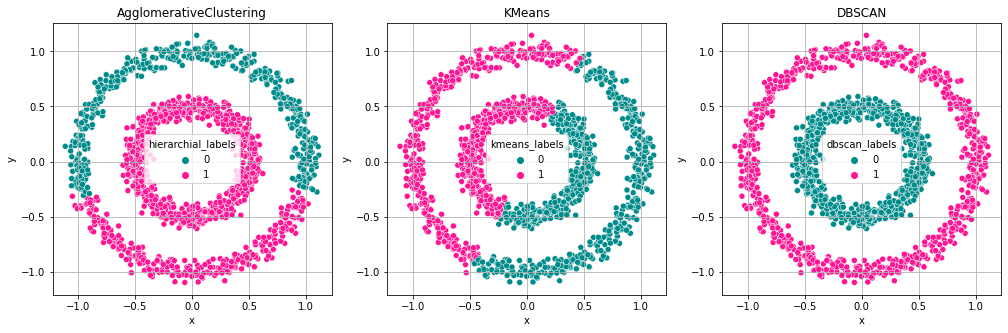

In [10]:
create_plot_for_clusters(noisy_circles_df)

### Интересные примеры

Сравнение различных алгоритмов кластеризации на "игрушечных датасетах"

https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

Сравнение различных видов связей в иерархической кластеризации на "игрушечных датасетах"

https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py

## Подсчет схожести строк

### Расстояние Левенштейна

Расстояние Левенштейна — минимальное количество операций вставки, удаления или изменения символа, необходимое для преобразования одной строки в другую.

In [11]:
str_1 = 'волынка'
str_2 = 'валенок'

Библиотечная реализация

In [12]:
levenshtein(str_1, str_2)

4

Кастомная реализация

In [13]:
str_1_len, str_2_len = len(str_1), len(str_2)
if str_1_len > str_2_len:
    # убедимся что str_1_len <= str_2_len, чтобы использовать минимум памяти O(min(str_1_len, str_2_len))
    str_1, str_2 = str_2, str_1
    str_1_len, str_2_len = str_2_len, str_1_len
# 0 ряд - просто восходящая последовательность (одни вставки)
current_row = range(str_1_len + 1)
for i in range(1, str_2_len + 1):
    previous_row, current_row = current_row, [i] + [0] * str_1_len
    for j in range(1, str_1_len + 1):
        add, delete, change = previous_row[j] + 1, current_row[j - 1] + 1, previous_row[j - 1]
        if str_1[j - 1] != str_2[i - 1]:
            change += 1
        current_row[j] = min(add, delete, change)
    # вывод промежуточных шагов
    print(current_row[1::])
    print()
print(f'Расстояние Левенштейна {current_row[str_1_len]}')

[0, 1, 2, 3, 4, 5, 6]

[1, 1, 2, 3, 4, 5, 5]

[2, 2, 1, 2, 3, 4, 5]

[3, 3, 2, 2, 3, 4, 5]

[4, 4, 3, 3, 2, 3, 4]

[5, 4, 4, 4, 3, 3, 4]

[6, 5, 5, 5, 4, 3, 4]

Расстояние Левенштейна 4


Подсчет меры схожести: отношение расстояния Левенштейна к максимальной длине строки.

In [14]:
def similarity_measure_lev(str_1, str_2):
    lev_dist = levenshtein(str_1, str_2)
    return 1 - lev_dist / max(len(str_1), len(str_2))

In [15]:
similarity_measure_lev(str_1, str_2)

0.4285714285714286

### Выравнивания

Выравнивание последовательностей — метод, основанный на размещении двух или более последовательностей друг под другом таким 
образом, чтобы легко увидеть сходные участки в этих последовательностях.

In [16]:
seq_1 = Seq('MASTERS')
seq_2 = Seq('STARS')

Библиотечная реализация

**Здесь цена выравнивания - количество совпадений.**

Поиск оптимальных выравниваний

In [17]:
alignments = align.globalxx(seq_1, seq_2)

for alignment in alignments:
    print(alignment)

Alignment(seqA='MASTE-RS', seqB='--ST-ARS', score=4.0, start=0, end=8)
Alignment(seqA='MASTERS', seqB='--STARS', score=4.0, start=0, end=7)


Форматирование оптимальных выравниваний

In [18]:
alignments = align.globalxx(seq_1, seq_2)
for alignment in alignments:
    print(format_alignment(*alignment))

MASTE-RS
  ||  ||
--ST-ARS
  Score=4

MASTERS
  ||.||
--STARS
  Score=4



Подсчет меры схожести: отношение оптимальной цены выравнивания к максимальной длине строки.

In [19]:
def alignment_method(prog_1, prog_2):
    aligner = Align.PairwiseAligner()
    aligner.match_score = 1.0
    seq_1 = Seq(prog_1)
    seq_2 = Seq(prog_2)
    score = aligner.score(seq_1, seq_2)
    return score / max(len(prog_1), len(prog_2))

In [20]:
alignment_method(seq_1, seq_2)

0.5714285714285714

## Задача поиска плагиата в программном коде

Задание. Выделить кластеры похожих решений. Ограничения: $0,99; 0,95; 0,9$

In [21]:
couples_df = pd.read_csv('example_1.csv')
couples_df

,stud_1,stud_2,lev_coef,align_coef,sol_1,sol_2
0,B,F,1.000000,1.000000,IOIIIOIOIIKKIIOIIIIIOIIIIKIIIIOININIIKKIIOIIIK...,IOIIIOIOIIKKIIOIIIIIOIIIIKIIIIOININIIKKIIOIIIK...
1,A,K,0.954955,0.954955,IOIIIOIIOIIKKIIOIIIIIOIIIIKIIIIOININIIKKNIIOII...,IOIIIOIIOIIKKNIIOIIIIIOIIIIKIIIIOININIOIIIIKKN...
2,G,N,0.930435,0.930435,IOIIOIIOIIIIOIIKIKIONOIOIONIOIIIIIIIKKIONIOIII...,KIIOIIOIIOIIIIOIIKIKIONOIOIONIOIIIIIIIKKNIONIO...
3,E,R,0.987903,0.987903,IIKIIIIIIIIIOIIIOIIIOIIIOIIIOIKIIKIIOOIIOOIIOO...,IIKIIIIIIIIIOIIIOIIIOIIIOIIIOIKIIKIIOOIIOOIIOO...
4,A,T,1.000000,1.000000,IOIIIOIIOIIKKNIIOIIIIIOIIIIKIIIIOININIOIIIIKKN...,IOIIIOIIOIIKKNIIOIIIIIOIIIIKIIIIOININIOIIIIKKN...
5,T,K,0.954955,0.954955,IOIIIOIIOIIKKNIIOIIIIIOIIIIKIIIIOININIOIIIIKKN...,IOIIIOIIOIIKKIIOIIIIIOIIIIKIIIIOININIIKKNIIOII...
6,A,S,0.954955,0.954955,IOIIIOIIOIIKKIIOIIIIIOIIIIKIIIIOININIIKKNIIOII...,IOIIIOIIOIIKKNIIOIIIIIOIIIIKIIIIOININIOIIIIKKN...
7,K,S,1.000000,1.000000,IOIIIOIIOIIKKIIOIIIIIOIIIIKIIIIOININIIKKNIIOII...,IOIIIOIIOIIKKIIOIIIIIOIIIIKIIIIOININIIKKNIIOII...
8,T,S,0.954955,0.954955,IOIIIOIIOIIKKIIOIIIIIOIIIIKIIIIOININIIKKNIIOII...,IOIIIOIIOIIKKNIIOIIIIIOIIIIKIIIIOININIOIIIIKKN...
9,J,F,0.970588,0.970588,IOIIIOIOIIKKIIOIIIIIOIIIIKIIIIOININIIKKNIIIOII...,IOIIIOIOIIKKIIOIIIIIOIIIIKIIIIOININIIKKIIOIIIK...


Расстояние Левенштейна

Кластеры при ограничении $0,99$

1) A, T

2) F, B

3) K, S

Кластеры при ограничении $0,95$

1) E, R

2) A, K, T, S

3) F, B, J

Кластеры при ограничении $0,9$

1) E, R

2) A, K, T, S

3) F, B, J

4) N, G

In [22]:
couples_df_2 = pd.read_csv('example_2.csv')
couples_df_2

,stud_1,stud_2,lev_coef,align_coef,sol_1,sol_2
0,B,F,1.000000,1.000000,IOIIIOIIKKIIOIIIIKIIIIIIIKKIKIONONONIIKKIIOIII...,IOIIIOIIKKIIOIIIIKIIIIIIIKKIKIONONONIIKKIIOIII...
1,D,L,0.921875,0.921875,IOIIIONOIOIIIKKIIIOIIIIIIIKKIIIKKIIIKKIONKIONO...,IOIIIONOIOIIIKKIIIOIIIOIIIIKIIIIKKNIIIKKNIIIKK...
2,A,H,1.000000,1.000000,IOIIIOIIKKNIIOIIOIIIIKIIIIIIIKKNIIIKKNIIOIIIIO...,IOIIIOIIKKNIIOIIOIIIIKIIIIIIIKKNIIIKKNIIOIIIIO...
3,E,R,0.962500,0.962500,KIKOIIOIIOIKIIIOIIKKIIIKKIONIIKIIIIIIIIONIOIII...,KIIOIIOIIOIIIIIOIIKKIIIKIIONIIKIIIIIIIIONIOIII...
4,A,T,1.000000,1.000000,IOIIIOIIKKNIIOIIOIIIIKIIIIIIIKKNIIIKKNIIOIIIIO...,IOIIIOIIKKNIIOIIOIIIIKIIIIIIIKKNIIIKKNIIOIIIIO...
5,H,T,1.000000,1.000000,IOIIIOIIKKNIIOIIOIIIIKIIIIIIIKKNIIIKKNIIOIIIIO...,IOIIIOIIKKNIIOIIOIIIIKIIIIIIIKKNIIIKKNIIOIIIIO...
6,M,F,1.000000,1.000000,IOIIIOIIKKIIOIIIIKIIIIIIIKKIKIONONONIIKKIIOIII...,IOIIIOIIKKIIOIIIIKIIIIIIIKKIKIONONONIIKKIIOIII...
7,B,M,1.000000,1.000000,IOIIIOIIKKIIOIIIIKIIIIIIIKKIKIONONONIIKKIIOIII...,IOIIIOIIKKIIOIIIIKIIIIIIIKKIKIONONONIIKKIIOIII...
8,F,S,1.000000,1.000000,IOIIIOIIKKIIOIIIIKIIIIIIIKKIKIONONONIIKKIIOIII...,IOIIIOIIKKIIOIIIIKIIIIIIIKKIKIONONONIIKKIIOIII...
9,B,S,1.000000,1.000000,IOIIIOIIKKIIOIIIIKIIIIIIIKKIKIONONONIIKKIIOIII...,IOIIIOIIKKIIOIIIIKIIIIIIIKKIKIONONONIIKKIIOIII...


Расстояние Левенштейна

Кластеры при ограничении $0,99$

1) A, H, T

2) F, B, M, S, J

Кластеры при ограничении $0,95$

1) A, H, T

2) F, B, M, S, J

3) E, R

Кластеры при ограничении $0,9$

1) A, H, T

2) F, B, M, S, J

3) E, R

4) L, D